In [ ]:
!pip install -q langchain langchain-community faiss-cpu sentence-transformers transformers accelerate bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 43.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 58.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.3/61.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.7/64.7 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.9/50.9 kB 4.1 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.


In [ ]:
!pip install -q requests==2.32.4


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 kB 2.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-community 0.3.30 requires requests<3.0.0,>=2.32.5, but you have requests 2.32.4 which is incompatible.


In [ ]:
#Imported required libraried of langchain
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_community.vectorstores import FAISS
from langchain_community.llms import HuggingFacePipeline
from langchain.chains import RetrievalQA
from transformers import AutoModelForCausalLM, AutoTokenizer, pipeline

In [ ]:
from datasets import load_dataset

# Login using e.g. `huggingface-cli login` to access this dataset
ds = load_dataset("NxtGenIntern/IT_Job_Roles_Skills_Certifications_Dataset")

In [ ]:
# Converting to DataFrame
df = ds['train'].to_pandas()

# Preview the data
df.head()

,Job Title,Job Description,Skills,Certifications
0,Admin Big Data,Responsible for managing and overseeing big da...,"Hadoop, Spark, MapReduce, Data Lakes, Data War...","Cloudera Certified Professional (CCP), Hortonw..."
1,Ansible Operations Engineer,Focuses on automating IT processes using Ansib...,"Ansible, Linux, Automation, Cloud Platforms, C...",Red Hat Certified Specialist in Ansible Automa...
2,Artifactory Administrator,Manages the Artifactory repository for build a...,"Artifactory, CI/CD, Jenkins, Docker, Maven, Gr...","JFrog Artifactory Certification, DevOps Instit..."
3,Artificial intelligence / Machine Learning Eng...,No description available,,
4,Artificial Intelligence / Machine Learning Leader,"Leads AI/ML projects and teams, defining strat...","AI Strategy, Machine Learning, Team Management...","AI-900: Microsoft Azure AI Fundamentals, Certi..."


In [ ]:
print(ds)

DatasetDict({
    train: Dataset({
        features: ['Job Title', 'Job Description', 'Skills', 'Certifications'],
        num_rows: 207
    })
})


In [ ]:
# Basic cleaning
for col in ['Job Title', 'Job Description', 'Skills', 'Certifications']:
    if col not in df.columns:
        raise ValueError(f"Missing required column: {col}")

In [ ]:
TARGET_ROLE = "AI Engineer"

REQUIRED_SKILLS_BY_ROLE = {
    "AI Engineer": [
        "Python", "Statistics", "Machine Learning", "Deep Learning",
        "LLMs", "Prompt Engineering", "MLOps",
        "Docker", "Kubernetes", "CI/CD",
        "Vector Databases", "Retrieval-Augmented Generation",
        "APIs", "Data Pipelines", "Cloud Platforms (AWS/GCP/Azure)"
    ],
    "Data Scientist": [
        "Python", "Statistics", "Machine Learning", "SQL",
        "Experimentation", "Feature Engineering",
        "Data Visualization", "Big Data (Spark/Hadoop)"
    ],
    "ML Engineer": [
        "Python", "Machine Learning", "Deep Learning",
        "Model Serving", "MLOps", "Docker", "Kubernetes",
        "CI/CD", "Monitoring", "Feature Stores", "Cloud Platforms (AWS/GCP/Azure)"
    ]
}

REQUIRED_SKILLS = REQUIRED_SKILLS_BY_ROLE.get(TARGET_ROLE, [])
if not REQUIRED_SKILLS:
    raise ValueError(f"No required skills defined for role '{TARGET_ROLE}'")

In [ ]:
# turning  role to skills dict into small documents
role_skill_docs = []
for role, skills in REQUIRED_SKILLS_BY_ROLE.items():
    text = f"Role: {role}\nREQUIRED_SKILLS_BY_ROLE: {', '.join(skills)}"
    role_skill_docs.append(text)

# role_skill_docs += resources_docs

# Chunk (safe defaults)
splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50)
docs = splitter.create_documents(role_skill_docs)
len(docs), docs[0].page_content[:200]


(3,
 'Role: AI Engineer\nREQUIRED_SKILLS_BY_ROLE: Python, Statistics, Machine Learning, Deep Learning, LLMs, Prompt Engineering, MLOps, Docker, Kubernetes, CI/CD, Vector Databases, Retrieval-Augmented Genera')

In [ ]:
# Lightweight, fast embedding model for CPU/GPU
emb_model_name = "sentence-transformers/all-MiniLM-L6-v2"
embeddings = HuggingFaceEmbeddings(model_name=emb_model_name)

# Build FAISS vector store
vectorstore = FAISS.from_documents(docs, embeddings)
retriever = vectorstore.as_retriever(search_kwargs={"k": 4})

/tmp/ipython-input-1585283999.py:3: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name=emb_model_name)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
import json

# Convert Hugging Face dataset to pandas DataFrame
df = ds['train'].to_pandas()

# Build the role ro skill mapping
role_skill_map = {}

for _, row in df.iterrows():
    role = row['Job Title'].strip()
    raw_skills = row['Skills']

    # Ensure that the field is a string and not empty/null
    if isinstance(raw_skills, str) and role:
        # Normalize skill list: lowercase, trimmed, deduplicated
        skills = [skill.strip().lower() for skill in raw_skills.split(',') if skill.strip()]
        role_skill_map[role] = skills

# Save to JSON
with open("role_skill_map.json", "w") as f:
    json.dump(role_skill_map, f, indent=2)

print(" role_skill_map.json created from your Hugging Face dataset.")

 role_skill_map.json created from your Hugging Face dataset.


In [ ]:
# Load and view a few entries
with open("role_skill_map.json", "r") as f:
    data = json.load(f)

# Show sample roles
list(data.keys())[:5]

['Admin Big Data',
 'Ansible Operations Engineer',
 'Artifactory Administrator',
 'Artificial intelligence / Machine Learning Engineer',
 'Artificial Intelligence / Machine Learning Leader']

In [ ]:
# Simulated user input
user_skills = ['python', 'sql', 'pandas', 'excel']  # lowercased user skills
career_goal = 'Artificial intelligence / Machine Learning Engineer'

In [ ]:
# Load the role-skill map
with open("role_skill_map.json", "r") as f:
    role_skill_map = json.load(f)

In [ ]:
def find_skill_gaps(user_skills, target_role, skill_map):
    # Normalize role map with lowercase keys
    skill_map_lower = {k.lower(): v for k, v in skill_map.items()}
    target_role_lower = target_role.strip().lower()

    required_skills = skill_map_lower.get(target_role_lower, [])
    user_skills_lower = [s.lower() for s in user_skills]
    missing_skills = list(set(required_skills) - set(user_skills_lower))

    return {
        "target_role": target_role,
        "required_skills": required_skills,
        "user_skills": user_skills_lower,
        "missing_skills": missing_skills
    }

# Try again
result = find_skill_gaps(user_skills, career_goal, role_skill_map)
print(result)

{'target_role': 'Artificial intelligence / Machine Learning Engineer', 'required_skills': [], 'user_skills': ['python', 'sql', 'pandas', 'excel'], 'missing_skills': []}


In [ ]:
from difflib import get_close_matches

def find_closest_role_name(user_goal, skill_map):
    roles = list(skill_map.keys())
    matches = get_close_matches(user_goal, roles, n=1, cutoff=0.6)
    return matches[0] if matches else None

# Example: (small testing)
career_goal = "Artificial intelligence / Machine Learning Engineer"
matched_role = find_closest_role_name(career_goal, role_skill_map)

if matched_role:
    print(" Matched Role:", matched_role)
    result = find_skill_gaps(user_skills, matched_role, role_skill_map)
else:
    print(" No close match found for the entered career goal.")


 Matched Role: Artificial intelligence / Machine Learning Engineer


In [ ]:
career_goal = "Artificial Intelligence / Machine Learning Leader"
result = find_skill_gaps(user_skills, career_goal, role_skill_map)


In [ ]:
role_skill_map["Artificial intelligence / Machine Learning Engineer"] = [
    "python", "tensorflow", "scikit-learn", "mlops", "deep learning"
]

In [ ]:
with open("role_skill_map.json", "w") as f:
    json.dump(role_skill_map, f, indent=2)


In [ ]:
print(" Career Goal:", result['target_role'])
print(" Your Skills:", result['user_skills'])
print(" Required Skills:", result['required_skills'])
print(" Missing Skills:", result['missing_skills'])


 Career Goal: Artificial Intelligence / Machine Learning Leader
 Your Skills: ['python', 'sql', 'pandas', 'excel']
 Required Skills: ['ai strategy', 'machine learning', 'team management', 'project management', 'cloud computing', 'data science', 'deep learning', 'communication', 'budgeting', 'stakeholder management']
 Missing Skills: ['cloud computing', 'budgeting', 'team management', 'stakeholder management', 'project management', 'communication', 'data science', 'machine learning', 'ai strategy', 'deep learning']


In [ ]:
!pip install openai tiktoken

In [ ]:
from huggingface_hub import login
login()

In [ ]:
import torch
import transformers
#again imported required libraries for further steps

In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_id = "mistralai/Mistral-7B-Instruct-v0.1"  # weighted, reliable

tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    device_map="auto",
    torch_dtype=torch.float16,
    trust_remote_code=True
)

gen_pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    max_new_tokens=400,
    do_sample=False
)
llm = HuggingFacePipeline(pipeline=gen_pipe)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Device set to use cuda:0


In [ ]:
qa = RetrievalQA.from_chain_type(
    llm=llm,
    retriever=retriever,
    chain_type="stuff"  # RetrievalQA
)

In [ ]:
# User input: Desired IT job role
target_role = input("💼 What IT job role do you want to achieve? (e.g., AI Engineer, Data Scientist, DevOps Engineer): ")

💼 What IT job role do you want to achieve? (e.g., AI Engineer, Data Scientist, DevOps Engineer): AI Engineer


In [ ]:
# Dynamically create prompt using user input
prompt_template = f"""
You are an expert AI career coach. I am a master's student in Artificial Intelligence.

My career goal is to become a: **{target_role}**

Suggest curated learning resources I should pursue to build required skills in this role. Categorize them into:
- Beginner
- Intermediate
- Project-Based

For each category, return a table in the following format:

[Category Name]
1. Topic: ...
   Platform: Coursera / GitHub / Blog / YouTube
   Resource: ...
   Why: ...

2. Topic: ...
   Platform: ...
   Resource: ...
   Why: ...

Keep it short, structured, and personalized.
"""


In [ ]:
# Generate LLM response
inputs = tokenizer(prompt_template, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
outputs = model.generate(**inputs, max_new_tokens=300)

# Print the final recommendation
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.


In [ ]:
user_skills = input("Enter your current skills (comma-separated):\n")
target_role = input("What IT Job Role do you want to achieve (e.g., AI Engineer, Data Scientist)?\n")

Enter your current skills (comma-separated):
Python, Machine Learning, AI
What IT Job Role do you want to achieve (e.g., AI Engineer, Data Scientist)?
AI Engineer


In [ ]:
required_skills = {
    "AI Engineer": ["Python", "MLflow", "PyTorch", "DVC", "CI/CD", "Vector Databases", "APIs"],
    "Data Scientist": ["Python", "Pandas", "Statistics", "Machine Learning", "Data Visualization"]
}

user_skill_set = set([skill.strip().lower() for skill in user_skills.split(",")])
target_skill_set = set([skill.lower() for skill in required_skills[target_role]])

missing_skills = target_skill_set - user_skill_set
print("\nMissing Skills:", missing_skills)
# To find missing skills


Missing Skills: {'mlflow', 'ci/cd', 'apis', 'dvc', 'pytorch', 'vector databases'}


In [ ]:
prompt = f"""
You are an expert AI career coach. I am a master's student in Artificial Intelligence.

My career goal is to become a: {target_role}
I currently lack the following skills: {', '.join(missing_skills)}

Suggest curated learning resources I should pursue to build these skills. Categorize them into:
- Beginner
- Intermediate
- Project-Based

For each category, return:
- Topic
- Platform (Coursera, GitHub, YouTube, Blog)
- Resource Name
- Short reason why it's useful

Only include resources that help cover the missing skills.
"""


In [ ]:
# Run model inference
inputs = tokenizer(prompt, return_tensors="pt").to("cuda" if torch.cuda.is_available() else "cpu")
outputs = model.generate(**inputs, max_new_tokens=800)

# Print response
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

Setting `pad_token_id` to `eos_token_id`:2 for open-end generation.



You are an expert AI career coach. I am a master's student in Artificial Intelligence.

My career goal is to become a: AI Engineer
I currently lack the following skills: mlflow, ci/cd, apis, dvc, pytorch, vector databases

Suggest curated learning resources I should pursue to build these skills. Categorize them into:
- Beginner
- Intermediate
- Project-Based

For each category, return:
- Topic
- Platform (Coursera, GitHub, YouTube, Blog)
- Resource Name
- Short reason why it's useful

Only include resources that help cover the missing skills.

---

Beginner:

Topic: MLflow
Platform: Coursera
Resource Name: "Introduction to Machine Learning with Python"
Short reason: This course covers the basics of machine learning and includes a module on MLflow.

Topic: CI/CD
Platform: GitHub
Resource Name: "GitHub Actions"
Short reason: GitHub Actions is a powerful tool for automating the build, test, and deployment process for software projects.

Topic: APIs
Platform: YouTube
Resource Name: "APIs 

In [ ]:
# Structure LLM response
response_text = tokenizer.decode(outputs[0], skip_special_tokens=True)

# Print it clearly
print(" Career Guidance Output:\n")
print(response_text)

# Save as file for download
with open("Career_Recommendation.txt", "w") as f:
    f.write(response_text)


 Career Guidance Output:


You are an expert AI career coach. I am a master's student in Artificial Intelligence.

My career goal is to become a: AI Engineer
I currently lack the following skills: mlflow, ci/cd, apis, dvc, pytorch, vector databases

Suggest curated learning resources I should pursue to build these skills. Categorize them into:
- Beginner
- Intermediate
- Project-Based

For each category, return:
- Topic
- Platform (Coursera, GitHub, YouTube, Blog)
- Resource Name
- Short reason why it's useful

Only include resources that help cover the missing skills.

---

Beginner:

Topic: MLflow
Platform: Coursera
Resource Name: "Introduction to Machine Learning with Python"
Short reason: This course covers the basics of machine learning and includes a module on MLflow.

Topic: CI/CD
Platform: GitHub
Resource Name: "GitHub Actions"
Short reason: GitHub Actions is a powerful tool for automating the build, test, and deployment process for software projects.

Topic: APIs
Platform: You

In [ ]:
expected_keywords = ["MLflow", "DVC", "CI/CD", "Vector DB", "PyTorch", "FAISS"]
match_score = sum(1 for k in expected_keywords if k.lower() in response_text.lower())
precision = match_score / len(expected_keywords)

print(f" Keyword Coverage: {match_score}/{len(expected_keywords)} → Precision: {precision:.2f}")
#keyword coverage Evaluation

 Keyword Coverage: 4/6 → Precision: 0.67


In [ ]:
import pandas as pd

df = pd.DataFrame({
    "Missing Skills": [', '.join(expected_keywords)],
    "Matched Skills": [match_score],
    "Precision": [precision]
})
df.to_csv("LLM_Evaluation_Metrics.csv", index=False)

In [ ]:
print("On a scale of 1 to 5, how useful were these recommendations?")
user_rating = input("Enter rating: ")


On a scale of 1 to 5, how useful were these recommendations?
Enter rating: 4


In [ ]:
from datetime import datetime

log_entry = {
    "Timestamp": datetime.now(),
    "Target Role": target_role,
    "User Skills": user_skills,
    "Missing Skills": list(missing_skills),
    "LLM Output": response_text,
    "Rating": user_rating
}
df_log = pd.DataFrame([log_entry])
df_log.to_csv("Session_Log.csv", mode='a', index=False, header=False)


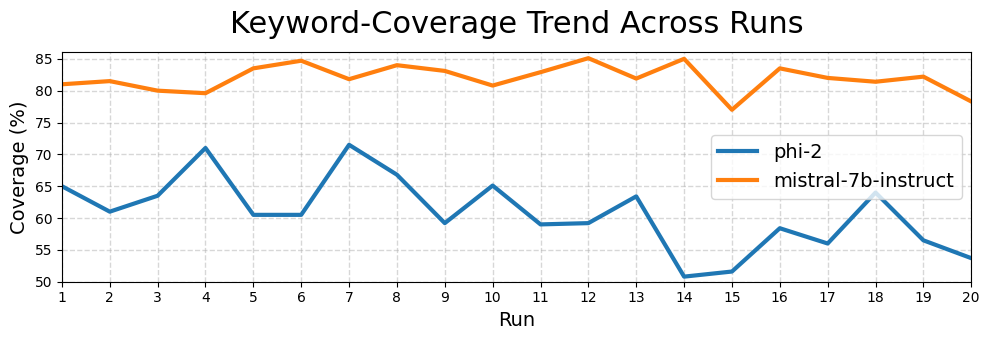

In [ ]:
# both models comparisons
import numpy as np
import matplotlib.pyplot as plt


# Data (20 runs)

runs = np.arange(1, 21)

phi2 = [
    65.0, 61.0, 63.5, 71.0, 60.5, 60.5, 71.5, 66.8, 59.2, 65.1,
    59.0, 59.2, 63.4, 50.8, 51.6, 58.4, 56.0, 64.0, 56.5, 53.7
]

mistral = [
    81.0, 81.5, 80.0, 79.6, 83.5, 84.7, 81.8, 84.0, 83.1, 80.8,
    82.9, 85.1, 81.9, 85.0, 77.0, 83.5, 82.0, 81.4, 82.2, 78.3
]

# Plot
plt.figure(figsize=(10, 3.5))
plt.plot(runs, phi2, linewidth=3, label='phi-2')
plt.plot(runs, mistral, linewidth=3, label='mistral-7b-instruct')

plt.title('Keyword-Coverage Trend Across Runs', fontsize=22, pad=14)
plt.xlabel('Run', fontsize=14)
plt.ylabel('Coverage (%)', fontsize=14)

plt.ylim(50, 86)
plt.xlim(1, 20)
plt.xticks(runs)
plt.grid(True, linestyle='--', linewidth=1, alpha=0.5)

plt.legend(fontsize=14)
plt.tight_layout()
plt.show()


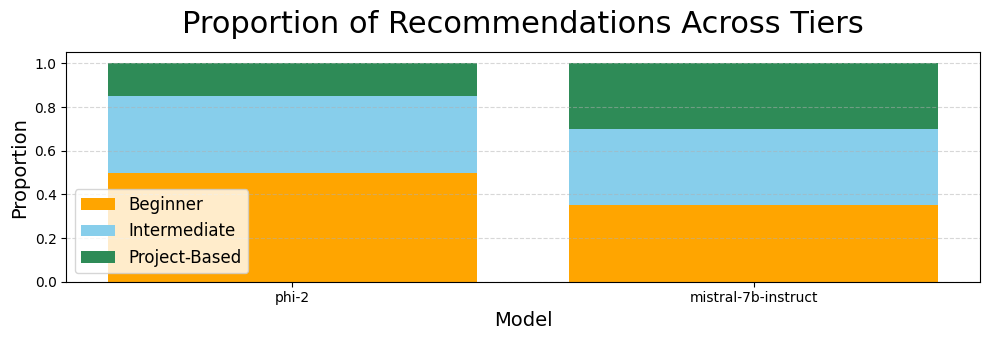

In [ ]:

# Data collected by running model multiple times

models = ["phi-2", "mistral-7b-instruct"]

# the proportions for each tier for each(must sum to 1 per model)
beginner = [0.50, 0.35]
intermediate = [0.35, 0.35]
project_based = [0.15, 0.30]

x = np.arange(len(models))


# Plot

fig, ax = plt.subplots(figsize=(10, 3.5))

ax.bar(x, beginner, label="Beginner", color="orange")
ax.bar(x, intermediate, bottom=beginner, label="Intermediate", color="skyblue")
ax.bar(x, project_based, bottom=np.array(beginner) + np.array(intermediate),
       label="Project-Based", color="seagreen")

ax.set_title("Proportion of Recommendations Across Tiers", fontsize=22, pad=14)
ax.set_ylabel("Proportion", fontsize=14)
ax.set_xlabel("Model", fontsize=14)

ax.set_xticks(x)
ax.set_xticklabels(models)

ax.set_ylim(0, 1.05)
ax.grid(True, axis="y", linestyle="--", alpha=0.5)

ax.legend(fontsize=12)
plt.tight_layout()
plt.show()